In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from typing import Callable, Tuple
import matplotlib

Util-функции

In [2]:
def create_plot(x, y_arrays, x_label, y_label, func_labels=None, colors=None, xPi=False,
                base=np.pi, marker=[None], linestyle=["-"], markersize=[10], linewidth=[1], markevery=None, log_y=False):
  fig, ax = plt.subplots()

  if markevery is None:
    markevery = [1] * len(y_arrays)
    markersize = [1] * len(y_arrays)
    marker = [None] * len(y_arrays)

  if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * (len(y_arrays) // 7 + 1)

  if type(x[0]) == list:
    for i, y in enumerate(y_arrays):
      if func_labels is not None:
        ax.plot(x[i], y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
                linewidth=linewidth[i], label=func_labels[i], markevery=markevery[i])
        ax.legend()
      else:
        ax.plot(x[i], y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
                linewidth=linewidth[i], markevery=markevery[i])
  else:
    for i, y in enumerate(y_arrays):
      if func_labels is not None:
        ax.plot(x, y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
                linewidth=linewidth[i], label=func_labels[i], markevery=markevery[i])
        ax.legend()
      else:
        ax.plot(x, y, color=colors[i], linestyle=linestyle[i], marker=marker[i], markersize=markersize[i],
              linewidth=linewidth[i], markevery=markevery[i])

  ax.grid(True)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  if xPi:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
      lambda val, pos: f'{int(val/np.pi)}π' if val % np.pi == 0 and val != 0 else
                    (f'{val/np.pi:.1f}π' if val != 0 else '0')
    ))

  if log_y:
    ax.set_yscale('log')
    
  return ax

def draw_subplots(axes_list, nrows=1, ncols=None, height=4, width=7):
  num_plots = len(axes_list)
  if ncols is None:
      ncols = (num_plots + nrows - 1) // nrows

  fig, axes = plt.subplots(nrows, ncols, figsize=(width * ncols, height * nrows))
  axes = np.array(axes).reshape(-1)

  for i, ax in enumerate(axes_list):
    for line in ax.get_lines():
      axes[i].plot(line.get_xdata(), line.get_ydata(), color=line.get_color(),
                   linestyle=line.get_linestyle(), marker=line.get_marker(),
                   markersize=line.get_markersize(), linewidth=line.get_linewidth(),
                   label=line.get_label())
    if ax.get_legend() is not None:
      axes[i].legend()
    axes[i].set_xlabel(ax.get_xlabel())
    axes[i].set_ylabel(ax.get_ylabel())
    axes[i].grid(True)

    if ax.xaxis.get_major_formatter() is not None:
      axes[i].xaxis.set_major_locator(ax.xaxis.get_major_locator())
      axes[i].xaxis.set_major_formatter(ax.xaxis.get_major_formatter())

  for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

Метод золотого сечения

In [3]:
def golden_ratio_method(
    f: Callable[[float], float], a: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (np.sqrt(5) - 1) / 2
    L0 = b - a
    L1 = K * L0
    x = b - L1
    y = a + L1
    
    fx, fy= f(x), f(y)
    
    for k in range(max_iter):
        L_next = K * (b - a)
        
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - L_next
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + L_next
            fy = f(y)
        
        if L_next < epsilon:
            break
    
    return (x, fx) if fx < fy else (y, fy)

Метод парабол

In [4]:
# Явная формула
def parabola_method(
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)
    
    for k in range(max_iter):
        try:
            u = c - ( (c - a)**2 * (f(c) - f(b)) - (c - b)**2 * (f(c) - f(a)) ) /  \
                ( 2 * ((c - a) * (f(c) - f(b)) - (c - b) * (f(c) - f(a))) )
            fu = f(u)
        except ZeroDivisionError:
            pass

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu
        
        if abs(a - c) < epsilon:
            break
    
    x_min = a if fa < fb else b
    return x_min, f(x_min)

# numpy.linalge.solve
def parabola_method_numpy   (
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)
    
    for k in range(max_iter):
        A = np.array([
            [a**2, a, 1],
            [c**2, c, 1],
            [b**2, b, 1]
        ])
        det = np.linalg.det(A)
        if not np.abs(det) < 1e-12:
            B = np.array([fa, fc, fb])
            a_coeff, b_coeff, _ = np.linalg.solve(A, B)
            try:
                u = -b_coeff / (2 * a_coeff)
            except ZeroDivisionError:
                pass
        fu = f(u)

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu
        
        if abs(a - c) < epsilon:
            break
    
    x_min = a if fa < fb else b
    return x_min, f(x_min)

Метод Брента

In [5]:
def brent_method(
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    x = w = v = c
    fx = fw = fv = f(c)
    K = (np.sqrt(5) - 1) / 2
    u = None
    
    for k in range(max_iter):
        if len({fx, fw, fv}) == 3:
            A = np.array([
                [x**2, x, 1],
                [w**2, w, 1],
                [v**2, v, 1]
            ])
            det = np.linalg.det(A)
            if not np.abs(det) < 1e-12:
                B = np.array([fx, fw, fv])
                a_coeff, b_coeff, _ = np.linalg.solve(A, B)
                try:
                    u = -b_coeff / (2 * a_coeff)
                except ZeroDivisionError:
                    pass

        if u is None or np.isnan(u) or u < a or u > b or abs(u - x) > abs(v - b)/2:
            if x < (a + b) / 2:
                u = x + K * (b - x)
            else:
                u = x - K * (x - a)

        fu = f(u)

        if fu < fx:
            if u < x:
                b = x
            else:
                a = x
            v, fv = w, fw
            w, fw = x, fx
            x, fx = u, fu
        else:
            if u < x:
                a = u
            else:
                b = u
            if fu <= fw or w == x:
                v, fv = w, fw
                w, fw = u, fu
            elif fu <= fv or v == x or v == w:
                v, fv = u, fu

        if abs(b - a) < epsilon:
            break

    return x, fx

In [6]:
def f1(x: float):
    return -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1

def f2(x: float):
    return -(np.log(x-2))**2 + (np.log(10-x))**2 - x**0.2

def f3(x: float):
    return -3*x * np.sin(0.75*x) + np.exp(-2*x)

def f4(x: float):
    return np.exp(3*x) + 5*np.exp(-2*x)

def f5(x: float):
    return 0.2*x * np.log(x) + (x-2.3)**2

Применим оптимизацию

In [7]:
functions = [f1, f2, f3, f4, f5]
intervals = [
    [-0.5, 0.5],
    [6, 9.9],
    [0, 2*np.pi],
    [0, 1],
    [0.5, 2.5]
]
results_all = []
errors_all = []
x_space = range(1, 51, 1)

for i, f in enumerate(functions):
    a, b = intervals[i]
    c = (a + b) / 2
    
    method_results = [
        [golden_ratio_method(f, a, b, max_iter=x)[0] for x in x_space],
        [parabola_method(f, a, c, b, max_iter=x)[0] for x in x_space],
        [parabola_method_numpy(f, a, c, b, max_iter=x)[0] for x in x_space],
        [brent_method(f, a, c, b, max_iter=x)[0] for x in x_space]
    ]

    reference_points = [res[-1] for res in method_results]
    method_errors = [
        [abs(x_k - reference_points[j]) for x_k in method_results[j]]
        for j in range(4)
    ]

    results_all.append(method_results)
    errors_all.append(method_errors)
    

Нарисуем графики

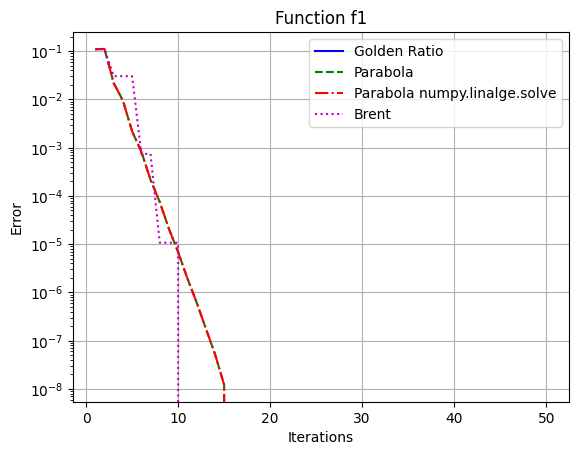

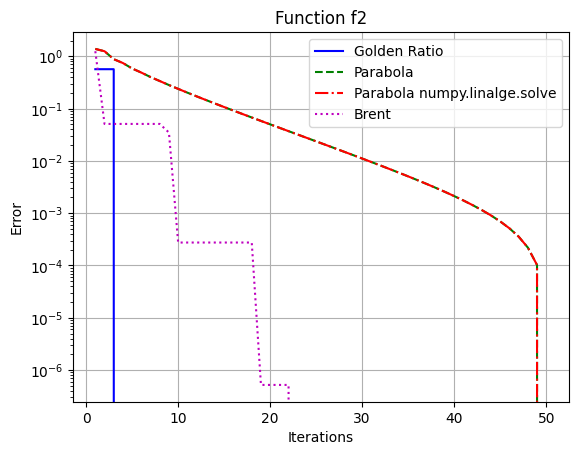

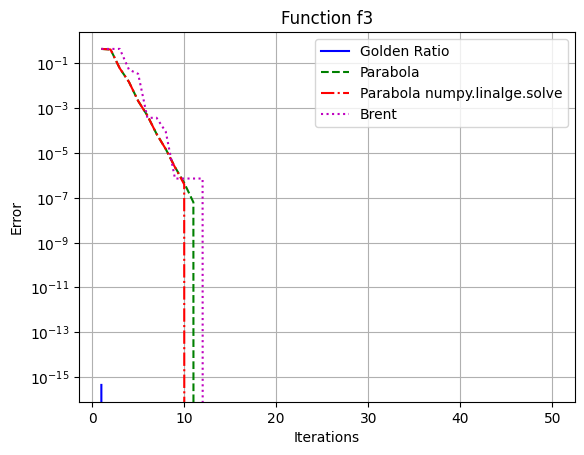

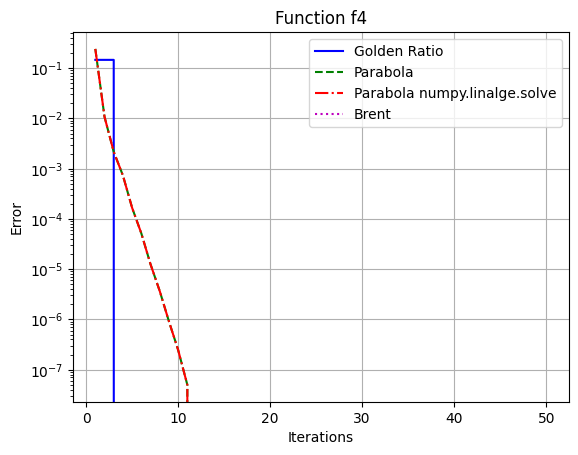

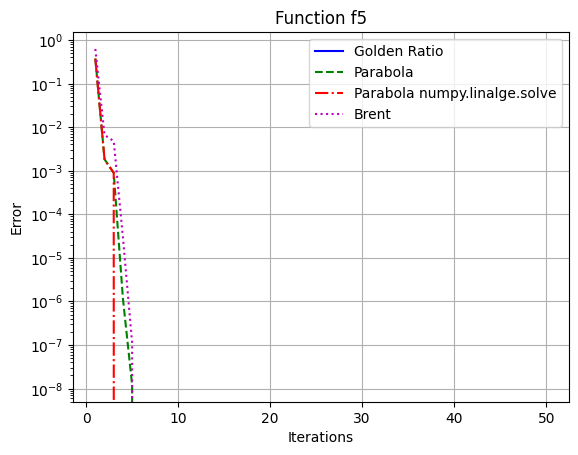

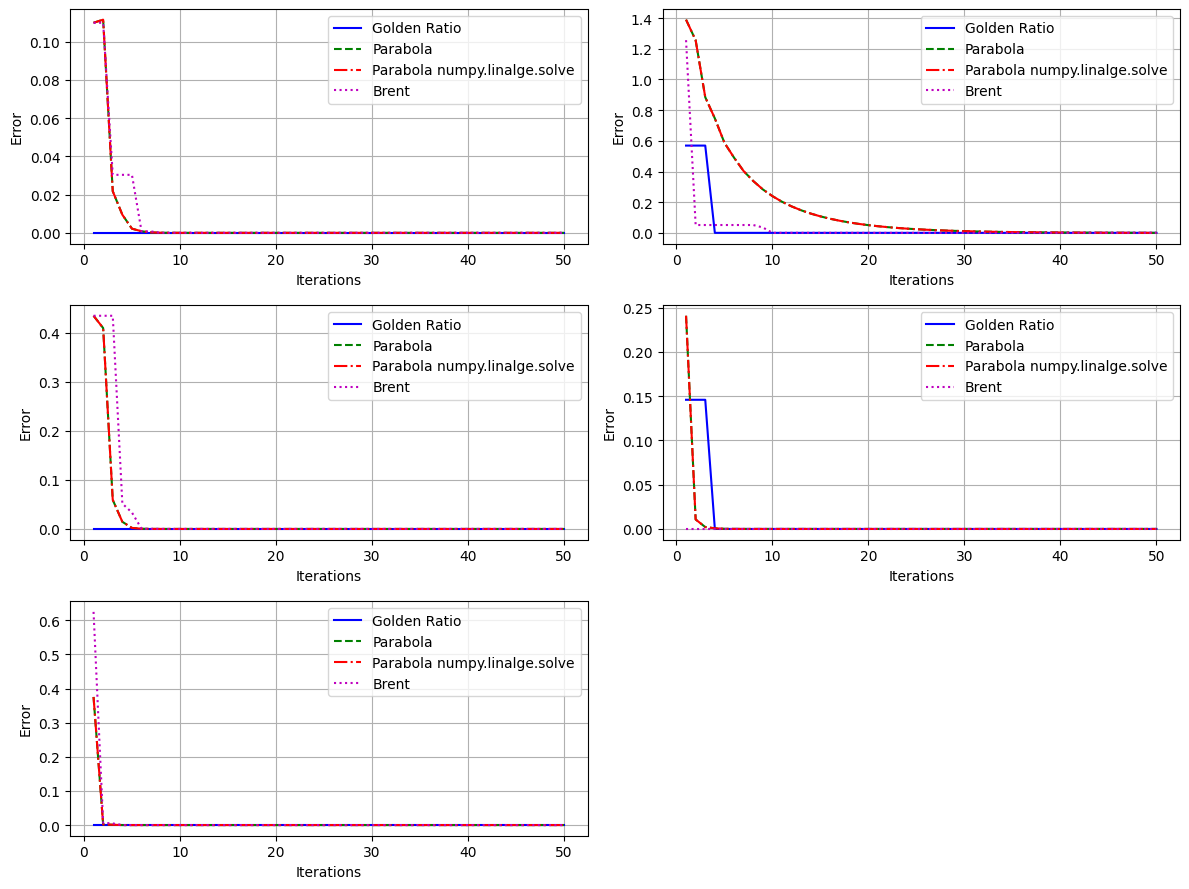

In [8]:
method_names = ["Golden Ratio", "Parabola", "Parabola numpy.linalge.solve", "Brent"]

axes_list = []
for i, error in enumerate(errors_all):
    ax = create_plot(
        x=x_space,
        y_arrays=error,
        x_label="Iterations",
        y_label="Error",
        func_labels=method_names,
        linestyle=["-", "--", "-.", ":"],
        linewidth=[1.5] * 4,
        colors=["b", "g", "r", "m"],
        log_y=True
    )
    ax.set_title(f"Function f{i+1}")
    axes_list.append(ax)

draw_subplots(axes_list, nrows=3, ncols=2, height=3, width=6)

In [9]:
plt.show()